## Ozone-depleting substance emissions

In [1]:
import json 
import pandas as pd 
import numpy as np 
import math 
import itertools 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure 
from load_dataset import TimeSeries 

In [2]:
# True labels
annotations = pd.read_json('TCPD-master/annotations.json')
annotations[['ozone']]

,ozone
6,[28]
7,[28]
8,[]
9,NaN
10,[28]
12,"[14, 28]"
13,NaN
14,NaN


In [3]:
# List true changepoints
annotator_df = pd.read_json('TCPD-master/annotations.json') 
ozone_df = annotator_df[['ozone']] 
list2d = np.array(ozone_df).flatten() 
list2d = [l for l in list2d if (type(l)==list)] 
ozone_annotation_lst = list(itertools.chain.from_iterable(list2d))
ozone_annotation_lst

[28, 28, 28, 14, 28]

t                    int64
Total Emissions    float64
date                object
dtype: object


<Figure size 960x480 with 0 Axes>

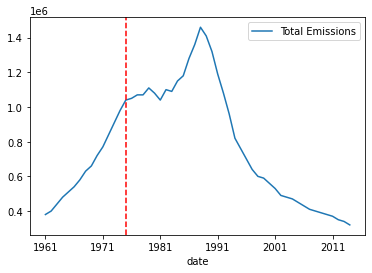

In [6]:
# Plot true changepoints
from load_dataset import TimeSeries
ts = TimeSeries.from_json('TCPD-master/datasets/ozone/ozone.json')
ozone_df = ts.df
ozone_df['date'] =ts.datestr
print(ozone_df.dtypes)
figure(figsize=(12, 6), dpi=80)
ozone_df.plot('date', 'Total Emissions')
ozone_df['is_CPD'] = np.where(ozone_df.t.isin(ozone_annotation_lst), 1,0)
plt.axvline(ozone_df.loc[ozone_df['is_CPD']==1][['t']].values[0], color='red', linestyle='--')

In [7]:
ozone_df[28:29]

,t,Total Emissions,date,is_CPD
28,28,1410000.0,1989,1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



total changepoints-->  1


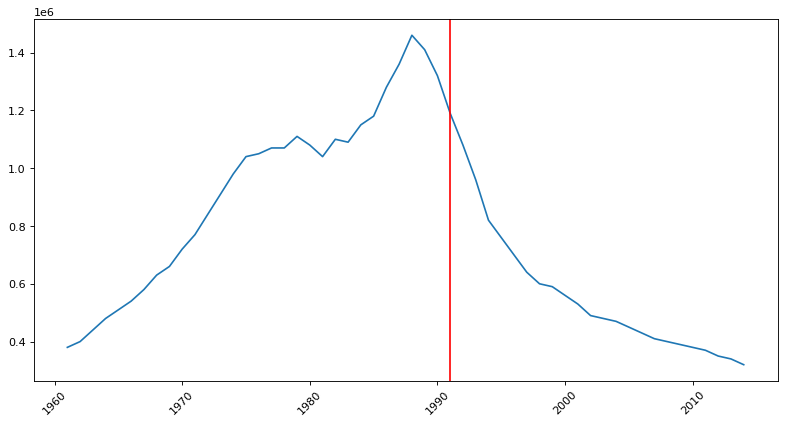

In [11]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.consts import TimeSeriesData

df = ozone_df
df['time']= pd.to_datetime(df['date'])


tsd = TimeSeriesData(df.loc[:,['time','Total Emissions']])

# Initialize the detector
detector = BOCPDetector(tsd)


changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=10,
    changepoint_prior=.5,#prior belief
    threshold=.7
)

print('total changepoints--> ', len(changepoints))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

In [12]:
changepoints

[(TimeSeriesChangePoint(start_time: 1991-01-01T00:00:00.000000000, end_time: 1991-01-01T00:00:00.000000000, confidence: 0.7192386553351017),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7ff4269c9910>)]

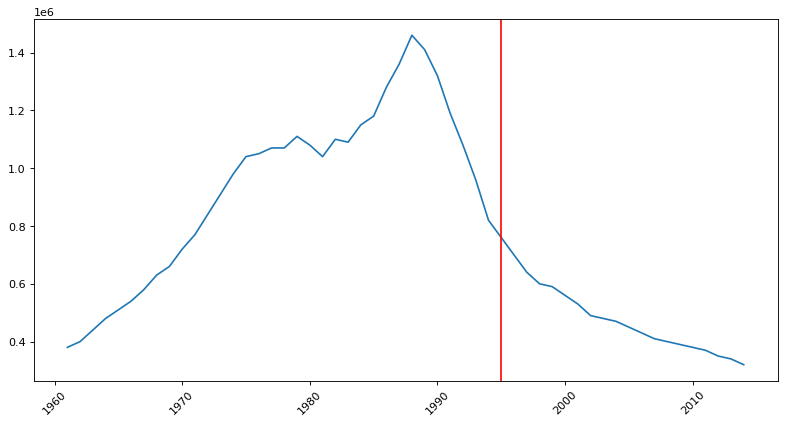

In [14]:
#Robust Stat Detector
from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(comparison_window=5, smoothing_window_size=5, p_value_cutoff=0.05)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [15]:
change_points

[(TimeSeriesChangePoint(start_time: 1995-01-01T00:00:00.000000000, end_time: 1995-01-01T00:00:00.000000000, confidence: 0.9688541668745517),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7ff426a2e610>)]

total changepoints-->  2


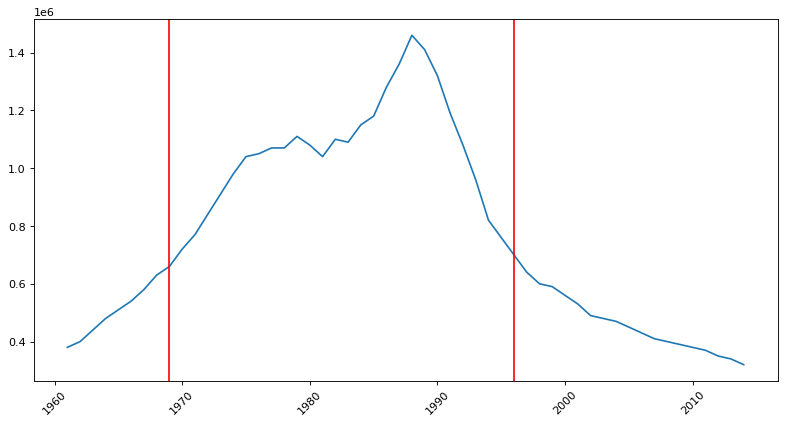

In [16]:
# CUSUM
from kats.detectors.cusum_detection import CUSUMDetector


# Initialize the detector
detector = CUSUMDetector(tsd)

change_points = detector.detector(threshold=0.05)

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [17]:
change_points

[(TimeSeriesChangePoint(start_time: 1969-01-01 00:00:00, end_time: 1969-01-01 00:00:00, confidence: 0.9637118444897322),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7ff4271135e0>),
 (TimeSeriesChangePoint(start_time: 1996-01-01 00:00:00, end_time: 1996-01-01 00:00:00, confidence: 0.9999998268458435),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7ff427113d00>)]

#### Annotation -> 1989
#### BOCPD -> 1991
#### RobustStatDetector -> 1995
#### CUSUM -> 1969, 1996